# Exploratoty Data Analysis: DM and Factors Related to 30 Day Readmissions 

### Abstract: 
______
#### Motivation
* In recent years, many hospitals have strived to reduce 30 day readmissions. Under healthcare reforms, providers are more accountable for patients following discharge. High levels of preventable readmissions result in penalties, and reduced federal reimbursement for services.

#### Goal:
* Explore factors that relate to 30 day readmissions. 


#### Hypotheses:
* Determine whether encounters that end with a patient leaving against medical advice have higher occurances of 30 day readmissions.
* Determine whether encounters that end with a patient being discharged to skilled nuring facilities have higher occurances of 30 day readmissions.
* Determine if patients admitted by Endocrinologists have lower 30 day readmission rates than those admitted by Internal Medicine physicians. 

#### Conclusions:
* Encounters that end with a patient leaving against medical advice have higher occurances of 30 day readmissions.
* Encounters that end with a patient being discharged to skilled nuring facilities have higher occurances of 30 day readmissions.
* Diabetic patients admitted by Endocrinologists have lower 30 day readmission rates than those admitted by Internal Medicine physicians. 
______


In [1]:
import os
import numpy as np
import pandas as pd
import scipy.stats as st
import scipy.special as sp
import statsmodels.stats.power as smpwr
from sklearn.preprocessing import LabelEncoder

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image

In [2]:
Image(url='http://assets.zipfianacademy.com/data/data-science-workflow/animate.gif', width=700)

Importing dataset & Data preparation
---

In [3]:
df= pd.read_csv(os.getcwd()+'/data'+'/diabetic_data.csv') # dataset
feats=pd.read_csv(os.getcwd()+'/data'+'/feature_descriptions.csv') # feature descriptions
maps= pd.read_csv(os.getcwd()+'/data'+'/IDs_mapping.csv') # Admission and Discharge ID definitions

### Data Preparation

In [4]:
df = df.replace('?', np.nan)

In [5]:
numeric_cols = df.describe().columns
nom_cols = [col for col in df.columns if col not in numeric_cols]
meds = nom_cols[11:-3]

In [6]:
df = df[df['gender']!='Unknown/Invalid']

df = df.drop('weight', axis=1)

df['admission_type_id'].unique()
df = pd.concat([df, pd.get_dummies(df[['gender','race','change','readmitted']])], axis=1)

# Replaces categorical fields with numeric values
for col in meds:
    df[col]=df[col].replace({'No': np.nan, 'Steady':0, 'Up':1, 'Down':-1})
    df[col] = df[col].astype(np.float64)

df['max_glu_serum'].replace({'>200': 2, '>300': 3, 'None': 0, 'Norm': 1},inplace=True)
df['A1Cresult'].replace({'>7': 2, '>8': 3, 'None': 0, 'Norm': 1},inplace=True)

labels_enc = LabelEncoder()
df['age'] = labels_enc.fit_transform(df['age'])

In [7]:
df = df.apply(lambda x: pd.to_numeric(x, errors='ignore'))  # Convert columns to numeric where possible
df['encounter_id'] = df['encounter_id'].astype(str)
df['patient_nbr'] = df['patient_nbr'].astype(str)
df['diag_1'] = df['diag_1'].astype(str)
df['diag_2'] = df['diag_2'].astype(str)
df['diag_3'] = df['diag_3'].astype(str)
df['admission_type_id'] = df['admission_type_id'].astype(str)
df['admission_source_id'] = df['admission_source_id'].astype(str)

In [8]:
encounters = df.groupby('patient_nbr').count()['encounter_id'].reset_index()
encounters.columns = ['patient_nbr', 'num_encounters']

In [9]:
readmissions = df.groupby('patient_nbr').agg(np.sum)[['readmitted_<30','readmitted_>30','readmitted_NO']].reset_index()
readmissions.columns = ['patient_nbr', 'num_readmits<30','num_readmits>30','num_not_readmitted']

In [10]:
counts_df=pd.merge(encounters,readmissions, on='patient_nbr', how='inner')

In [11]:
gender=df.groupby(['patient_nbr','gender']).agg(np.mean)['gender_Male'].reset_index()
counts_df=pd.merge(counts_df,gender[['patient_nbr','gender_Male']], on='patient_nbr', how='inner')

In [12]:
# Obtains encounters where patients left the hospital against medical advice
df['ama'] = df['discharge_disposition_id'] == 7
df['ama'] = df['ama'].astype(int)
df['snf'] = df['discharge_disposition_id'] == 3
df['snf'] = df['snf'].astype(int)

dispos = df.groupby('patient_nbr').agg(np.sum)[['ama','snf']].reset_index()
dispos.columns = ['patient_nbr', 'num_ama', 'num_snf']

In [13]:
counts_df=pd.merge(counts_df,dispos, on='patient_nbr', how='inner')

counts_df['num_readmits'] = counts_df['num_readmits<30']+counts_df['num_readmits>30']
counts_df['has_left_ama'] = counts_df['num_ama'] > 0
counts_df['has_left_ama'] =counts_df['has_left_ama'].astype(int)
counts_df['readmit_perc'] = counts_df['num_readmits<30'] / counts_df['num_encounters']

In [14]:
df['medical_specialty']=df['medical_specialty'].fillna('missing')

counts = df.groupby(['patient_nbr','medical_specialty']).count()['encounter_id'].reset_index()
counts.columns=['patient_nbr', 'medical_specialty', 'specialty_admits']

admit_types = counts.groupby('patient_nbr').count()['specialty_admits'].reset_index()

counts_df = pd.merge(counts_df,admit_types,how='inner',on='patient_nbr')

In [15]:
specialty = df[['medical_specialty','encounter_id']].groupby(['medical_specialty']).count()

specialty.columns = ['num_specialty_admits']
specialty = specialty.reset_index()
specialty_readmits = df[['medical_specialty','readmitted_<30','readmitted_>30','readmitted_NO']].groupby('medical_specialty').agg(np.sum)[['readmitted_<30','readmitted_>30','readmitted_NO']].reset_index()
specialty = pd.merge(specialty, specialty_readmits, how='inner', on='medical_specialty')
specialty['fail_rate']= specialty['readmitted_<30']/specialty['num_specialty_admits']

In [16]:
means = df[['patient_nbr','age','time_in_hospital','num_lab_procedures','num_procedures','num_medications','number_diagnoses','max_glu_serum', 'A1Cresult']]
means=means.groupby('patient_nbr').agg(np.mean).reset_index()
counts_df = pd.merge(counts_df,means,how='inner',on='patient_nbr')
counts_df['age']=np.round(counts_df['age'])

To get a sense for the data, lets make a correlation matrix using seaborn's heatmap plot. This will show the correlations that exist between our features.

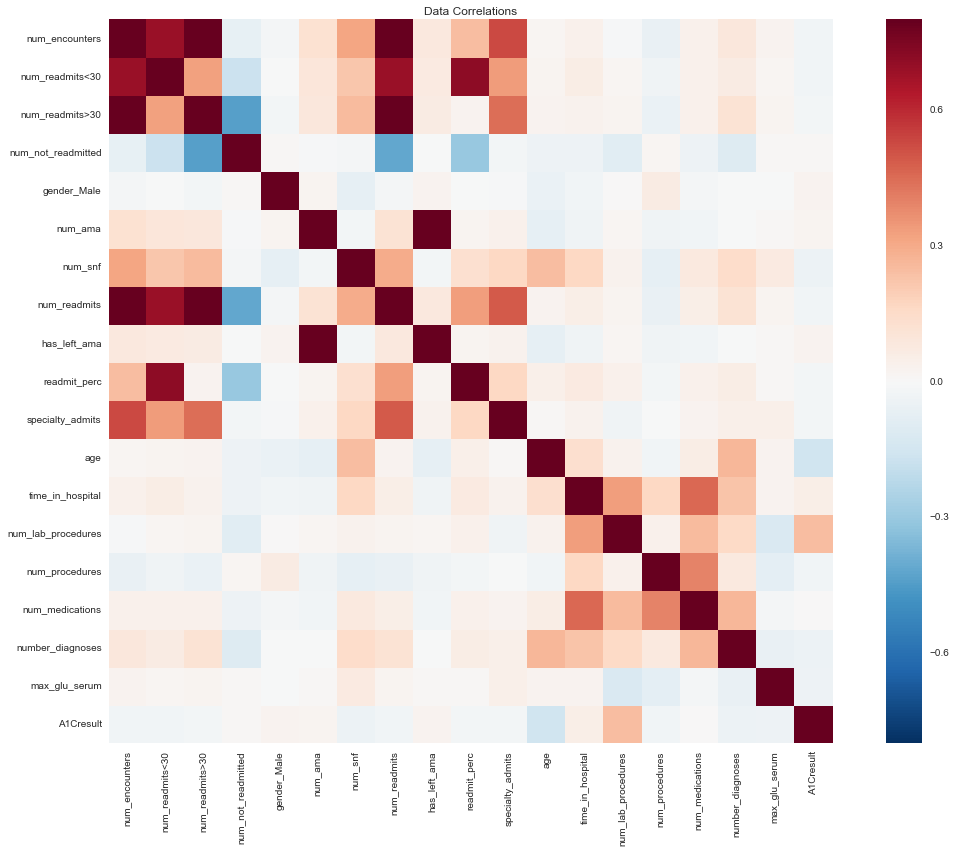

In [17]:
corrmat = counts_df.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 12))

# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax=.8, square=True)
ax.set_title('Data Correlations')
f.tight_layout()

Just from this few lines of code we recieve a wealth of insight about how our features correlate with one another. This helps us to gain a better understanding of the dataset and generate hypotheses.

Analysis
---
_____________
### Hypothesis 1
#### Determine whether encounters that end with a patient leaving against medical advice have higher occurances of 30 day readmissions.

Hypothesis:
* Null - The variables 'ama' and 'readmitted_<30' are independent. Meaning knowing the value of one of these features does not help in predicting the other.  
* Alternative = The variables 'ama' and 'readmitted_<30' are dependent. Meaning knowing the value of one of these features can help in predicting the other.  

Analysis plan: 
* Test method. Use the chi-square test for independence to determine whether there is a significant relationship between two categorical variables. For this analysis we will use a significance level of 0.05.


##### Chi-squared Test of Independence

* Nonparametric - assumes the data is not normally distributed
* Determines whether an association exists between 2 categorical variables.
* Null: There is no association between the two variables.
* Alternate: There is an association between the two variables.


#### Use cases:
• Show a causal relationship or independence between one input and output variable.

In [18]:
from scipy.stats import chi2_contingency

def chisq_of_df_cols(df, c1, c2):
    contingency_table=pd.crosstab(index=df[c1], columns=df[c2])
    return chi2_contingency(contingency_table, correction=False)

test_stat, pval, deg_freedom, expected = chisq_of_df_cols(df, 'ama', 'readmitted_<30')


test_stat, pval

(6.8266016116550023, 0.0089809983586184913)

Interpretation:  
Since the P-value (0.008) is less than the significance level (0.05), we cannot accept the null hypothesis. Thus, we conclude that there is a relationship between leaving against medical advice and 30 day readmissions. If we look at the bar plot below we can verify our findings. We see that encounters that end with a patient leaving against medical advice also have a higher prevelance of 30 day readmissions.

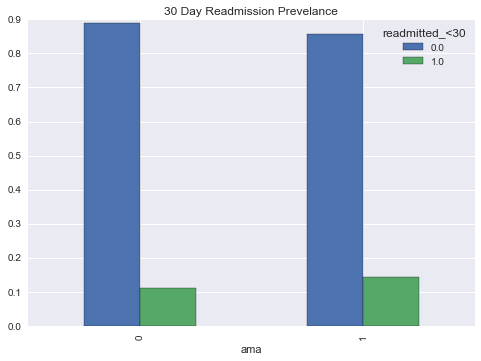

In [19]:
contingency_table=pd.crosstab(index=df['ama'], columns=df['readmitted_<30'])
contingency_table.astype('float').div(contingency_table.sum(axis=1),axis=0).plot(kind='bar',legend=True, title='30 Day Readmission Prevelance')

### Hypothesis 2
#### Determine whether encounters that end with a patient being discharged to a skilled nursing facility have higher occurances of 30 day readmissions.

Hypothesis:
* Null - The variables 'snf' and 'readmitted_<30' are independent. Meaning knowing the value of one of these features does not help in predicting the other.  
* Alternative = The variables 'snf' and 'readmitted_<30' are dependent. Meaning knowing the value of one of these features can help in predicting the other.  

Analysis plan: 
* Test method. Use the chi-square test for independence to determine whether there is a significant relationship between two categorical variables. For this analysis we will use a significance level of 0.05.

In [20]:
test_stat, pval, deg_freedom, expected = chisq_of_df_cols(df, 'snf', 'readmitted_<30')
test_stat, pval

(200.05745424269344, 2.0290563340097969e-45)

Interpretation:  
Since the P-value (2.0290563340097969e-45) is less than the significance level (0.05), we cannot accept the null hypothesis. Thus, we conclude that there is a relationship between skilled nursing facility discharges and 30 day readmissions. If we look at the bar plot below we can verify our findings. We see that encounters that end with a patient being discharged to a skilled nursing facility also have a higher prevelance of 30 day readmissions.

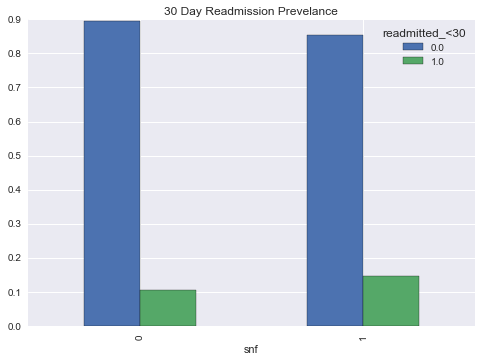

In [21]:
contingency_table=pd.crosstab(index=df['snf'], columns=df['readmitted_<30'])
contingency_table.astype('float').div(contingency_table.sum(axis=1),axis=0).plot(kind='bar',legend=True, title='30 Day Readmission Prevelance')

A/B Test using Bayesian Approach
---
### Hypothesis 3
#### Determine if patients admitted by Endocrinologists have lower 30 day readmission rates than those admitted by Internal Medicine physicians.

This analysis focuses on finding the true frequency of 30 day readmissions based on observed frequencies of different medical specialties. The true frequency can be interpreted as the probability of an event occurring. For example, the true frequency of getting heads when flipping a fair coin is 1/2. 

Conversely, the observed frequency is what is actually observed. An example being if we flipped a coin 100 times we may observe 40 heads, and 60 tails. Therefore the observed frequency often differs from the true frequency. However, by applying a bayesian approach we can obtain a better sense of the true frequencies, allowing us to compare the likelihood of 30 day readmissions for different medical specialties.

To infer a probable value for the true frequency we can use the observed occurences in our dataset. Here we will compare the 30 day readmission rates of endocrinologists and internal medicine physicians.  But first lets see how 30 day readmissions vary among all specialties:


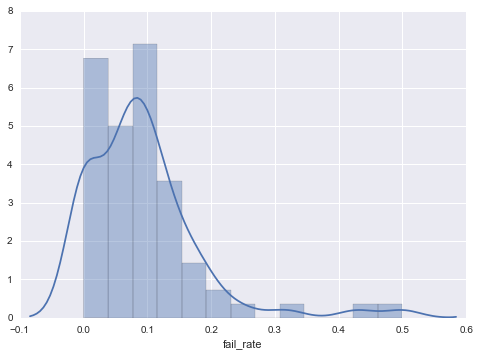

In [22]:
endo=specialty[specialty['medical_specialty'] == 'Endocrinology']
im = specialty[specialty['medical_specialty'] == 'InternalMedicine']
sns.distplot(specialty['fail_rate'])

The plot above shows the distribution of 30 day readmission rates among all medical specialties. We can see that majority of specialties fall somewhere between 0 and 20%. As stated above, this analysis will focus Endocrinologists and Internal Medicine physicians, both of which fall within this window.

First we assign our probabilities based on the observed readmission rates amongst Endocrinologists and Internal Medicine. Then we assign the number of admissions for each specialties based off the observations seen in our own dataset. After this we can generate new observations using what was observered in the data. Our generated samples are made using a Bernoulli distribution, meaning all values are 0 or 1. 
* 0's represent admitted patients who were not readmitted within 30 days.
* 1's represent admitted patients who were readmitted within 30 days.

All variables including A refer to endocrinologist patients and all variables including B refer to internal medicine patients.

In [23]:
import pymc as pm

# Probabilities based on the observed readmission rates amongst Endocrinologists and Internal Medicine.
true_p_A = endo['fail_rate'].values[0]
true_p_B = im['fail_rate'].values[0]


# Sample size based on the observed number of admissions. Unequal sample sizes are acceptable in this type of Bayesian analysis.
N_A = endo['num_specialty_admits'].values[0]
N_B = im['num_specialty_admits'].values[0]

# Generates new observations based on what was observered in the data using a Bernoulli distribution.
observations_A = pm.rbernoulli(true_p_A, N_A)
observations_B = pm.rbernoulli(true_p_B, N_B)
print "Patient readmitted within 30 days (Endocrinologists): \n", observations_A[:30].astype(int), "..."
print "Patient readmitted within 30 days (Internal Medicine): \n", observations_B[:30].astype(int), "..."

Patient readmitted within 30 days (Endocrinologists): 
[0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1] ...
Patient readmitted within 30 days (Internal Medicine): 
[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0] ...


In [24]:
print observations_A.mean()
print observations_B.mean()

# Occurrences.mean is equal to n/N.
print "Observed frequency of 30-readmits for Endocrinologists: %.4f" % observations_A.mean()
print "Does this equal the true frequency in original dataset? %s" % (observations_A.mean() == true_p_A)
print
print "Observed frequency of 30-readmits for Internal Medicine MDs: %.4f" % observations_B.mean()
print "Does this equal the true frequency in original dataset? %s" % (observations_B.mean() == true_p_B)

0.0583333333333
0.112880081995
Observed frequency of 30-readmits for Endocrinologists: 0.0583
Does this equal the true frequency in original dataset? False

Observed frequency of 30-readmits for Internal Medicine MDs: 0.1129
Does this equal the true frequency in original dataset? False


Next we assign our priors to a Uniform distibution. This is a conservative approach, which should be utilized when you do not possess a firm belief about the prior distribution. Then we must define the deterministic delta function. Delta, the return value from this function, represents our estimates of the true frequencies. Finally, we generate observations for our model and use a Markov Chain Monte Carlo model to return samples from the posterior distribution.  

In [25]:
# Set up the pymc model. Again assume Uniform priors for p_A and p_B.
p_A = pm.Uniform("p_A", 0, 1)
p_B = pm.Uniform("p_B", 0, 1)


# Define the deterministic delta function. This is our unknown of interest.
@pm.deterministic
def delta(p_A=p_A, p_B=p_B):
    return p_A - p_B

# Set of observations, in this case we have two observation datasets.
obs_A = pm.Bernoulli("obs_A", p_A, value=observations_A, observed=True)
obs_B = pm.Bernoulli("obs_B", p_B, value=observations_B, observed=True)

# To be explained in chapter 3.
mcmc = pm.MCMC([p_A, p_B, delta, obs_A, obs_B])
mcmc.sample(20000, 1000)

 [-----------------100%-----------------] 20000 of 20000 complete in 8.2 sec

Below assigns our posterior samples according to class and our delta.

In [26]:
from IPython.core.pylabtools import figsize
p_A_samples = mcmc.trace("p_A")[:]
p_B_samples = mcmc.trace("p_B")[:]
delta_samples = mcmc.trace("delta")[:]

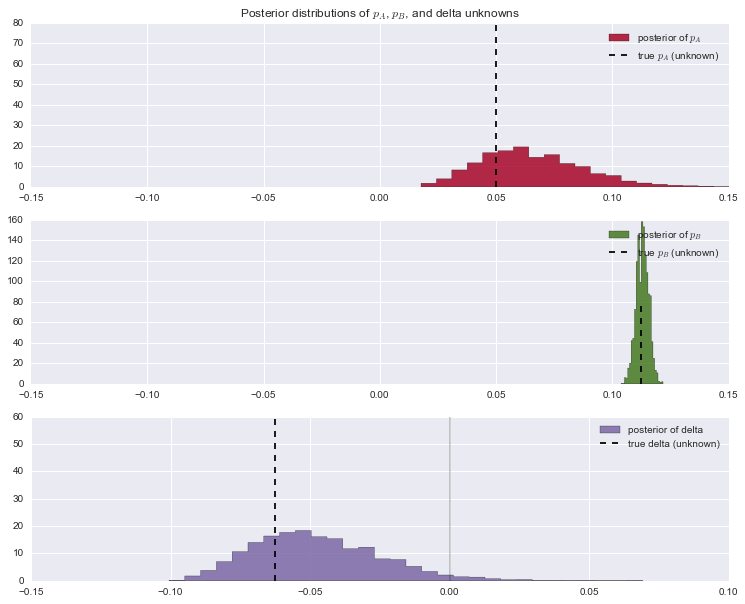

In [27]:
figsize(12.5, 10)

# histogram of posteriors

ax = plt.subplot(311)

plt.xlim(-0.15, .15)
plt.hist(p_A_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_A$", color="#A60628", normed=True)
plt.vlines(true_p_A, 0, 80, linestyle="--", label="true $p_A$ (unknown)")
plt.legend(loc="upper right")
plt.title("Posterior distributions of $p_A$, $p_B$, and delta unknowns")

ax = plt.subplot(312)

plt.xlim(-0.15, .15)
plt.hist(p_B_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_B$", color="#467821", normed=True)
plt.vlines(true_p_B, 0, 80, linestyle="--", label="true $p_B$ (unknown)")
plt.legend(loc="upper right")

ax = plt.subplot(313)
plt.hist(delta_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of delta", color="#7A68A6", normed=True)
plt.vlines(true_p_A - true_p_B, 0, 60, linestyle="--",
           label="true delta (unknown)")
plt.vlines(0, 0, 60, color="black", alpha=0.2)
plt.legend(loc="upper right");

Because there is have less admissions for endocrinologists, our posterior distribution of pA is fatter, implying we are less certain about the true value of pA than we are of pB.

We can see that the majority of the posterior distribution of delta is below delta=0, implying that internal medicine addmissions are more likely to be readmitted than patients admitted by an endocrinologist. The probability that this inference is incorrect is computed below:

In [28]:
# Count the number of samples less than 0, i.e. the area under the curve
# before 0, represents the probability that endocrinologists patients are less likely to be readmitted than internal medicine patients.
print "Probability Endocrinology has LESS 30 day readmissions than Internal Medicine: %.3f" % \
    (delta_samples < 0).mean()

print "Probability Endocrinology has MORE 30 day readmissions than Internal Medicine: %.3f" % \
    (delta_samples > 0).mean()

Probability Endocrinology has LESS 30 day readmissions than Internal Medicine: 0.971
Probability Endocrinology has MORE 30 day readmissions than Internal Medicine: 0.029


Therefore we can state the probability of a diabetic patient being readmitted within 30 days is significantly less if they are admitted by an Endocrinologist, rather than an internal medicine physician.